[View in Colaboratory](https://colab.research.google.com/github/sungreong/Pymc3_bayseian/blob/master/API_quickstart_(Pymc3).ipynb)

## Reference : https://docs.pymc.io/notebooks/api_quickstart.html#1.-Model-creation

In [0]:
!pip install git+https://github.com/pymc-devs/pymc3
!pip install patsy pandas

In [3]:
%matplotlib inline
import numpy as np
import theano.tensor as tt
import pymc3 as pm

import seaborn as sns
import matplotlib.pyplot as plt

sns.set_context("notebook")
plt.style.use("seaborn-darkgrid")
print('Running on PyMC3 v{}'.format(pm.__version__))

Running on PyMC3 v3.4.1


## Model creation
* 모든 확률 변수들과 모델 log(p)  그리고 gradients 계산 할 수 있다.
* 보통 **with** 을 이용하여 인스턴트화 한다.

In [0]:
with pm.Model() as model :
    pass

In [0]:
with pm.Model() as model :
    mu = pm.Normal("mu" , mu=0, sd=1)
    obs = pm.Normal("obs" , mu=mu , sd= 1 , observed = np.random.randn(100))

In [7]:
model.basic_RVs

[mu, obs]

In [6]:
model.free_RVs

[mu]

In [11]:
model.observed_RVs

[obs]

In [13]:
model.logp({"mu" : 10 })

# logp는 

array(-5109.90513475)

In [14]:
%timeit model.logp({mu: 0.1})
logp = model.logp
%timeit logp({mu : 0.1})

## logp = model.logp  inner loop 를 돌수 있게 해준다 .

10 loops, best of 3: 78 ms per loop
The slowest run took 5.28 times longer than the fastest. This could mean that an intermediate result is being cached.
10000 loops, best of 3: 27.9 µs per loop


# 2 Probability Distributions 
* 모든 확률 프로그램은 관측된 것과 관측되지 않은 확률변수로 이루어졌다. 
* 관측된 확률변수는 **가능도 함수**로 정의되고
 
  *관측되지 않은 확률 변수들은  **사전 분포** 로 정의된다
  
  

In [15]:
dir(pm.distributions.mixture)

['Discrete',
 'Distribution',
 'Mixture',
 'Normal',
 'NormalMixture',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 'all_discrete',
 'bound',
 'draw_values',
 'generate_samples',
 'get_tau_sd',
 'get_variable_name',
 'logsumexp',
 'np',
 'tt']

## 관측되지 않는 확률변수들

       *모든 관측되지 않는 확률변수는  **name(str) , parameter keyword argument** 를 호출해서 사용해야 한다 

In [0]:
with pm.Model() :
    x = pm.Normal("x" , mu=0 , sd=1 )

In [18]:
x.logp({"x" : 0 })

array(-0.91893853)

# 관측되는 확률변수들

* 관측된 확률변수는 말 그대로 **observed keyword** 인 **data** 가 필요하다 

In [0]:
with pm.Model() :
    obs = pm.Normal("x" , mu = 0 ,sd=1 , observed = np.random.randn(100) )

## Deterministic transforms 

모든 방법으로 확률변수의 선형을 자유롭게 표현 가능하다.

In [0]:
with pm.Model() :
    x= pm.Normal("x", mu=0, sd=1)
    y= pm.Gamma("y", alpha = 1, beta = 1)
    plus_2 = x+2
    summed = x+y
    squared = x**2
    sined = pm.math.sin(x)
    
    

* 겉보기에는 잘 작동하는 것 같아 보이지만 나오는 결과는 자동적으로 저장되지 않는다.
* 그러므로 만약 변현도니 변수를 알아보고 싶다면 너는 **pm.Deterministic** 을 반드시 사용해야한다.

In [0]:
with pm.Model() as model:
    x= pm.Normal("x", mu=0 , sd=1)
    plus_2 = pm.Deterministic("x plus 2", x+2)
    

## Automatic transforms of bounded RVS

모델을 효율적으로 샘플링하기 위해 경계가 없는 것을 경계를 만드는 것으로 변형 시킬 수 있다.


In [0]:
with pm.Model() as model :
    x = pm.Uniform("x", lower =0 ,upper=1)

In [28]:
model.free_RVs

## x_interval__ -inf 와 inf 사이 값인 것을 변형시킨 것이다



[x_interval__]

In [29]:
model.deterministics

[x]

결과를 볼 때 pymc3는 변형된 모수를 숨길긴다. 그래서 너는 **includ_transformed =True** 를 사용하면 된다.

In [30]:
with pm.Model() as model:
    x = pm.Uniform('x', lower=0, upper=1, transform=None)

print(model.free_RVs)

[x]


## List of RVs  / Higher-dimensional RVs

위에서는 scalar RVs 였다면 이제는 Multiple RVs를  사용하고 싶을 것이다.

In [0]:
with pm.Model() :
    x = [pm.Normal("x_{}".format(i), mu = 0 ,sd=1) for i in range(10)] # bad bad

In [0]:
### good 
with pm.Model() as model:
    x = pm.Normal('x', mu=0, sd=1, shape=10) 

## Initialization with test_values 

*pymc3 가 자동적으로 모델을 초기화 화는 동안 때때로 확류변수를 초기화하는 것에 유익하다 

**testval**

In [34]:
with pm.Model() :
    x= pm.Normal("x", mu=3, sd=1 ,shape=5)
    
x.tag.test_value

array([3., 3., 3., 3., 3.])

In [36]:
with pm.Model() :
    x= pm.Normal("x", mu=0, sd=1 ,shape=5, testval = np.random.randn(5))
    
x.tag.test_value

## This technique is quite useful to identify problems with model specification or initialization. 

array([ 0.30653659, -1.08127852, -0.63772912, -0.98126662, -0.74088514])

## Inference 
* 사후분포를 근사화하는 추론을 수행하고 싶다 
* pymc3 는  1. sampling  2. variantional inference  를 지원한다.

### Sampling 

*  **MCMC = pm.Sample() ** 
*  자동으로 좋은 샘플링 기법을 할당해주고, 자동으로 초기화 해준다 


In [37]:
with pm.Model() as model :
    mu = pm.Normal("mu" , mu=0 , sd=1) ## prior unobserved RVs
    obs = pm.Normal("obs", mu=mu, sd=1 ,observed = np.random.randn(100 )) ##  observed 
    
    trace = pm.sample(1000, tune= 500)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [mu]
100%|██████████| 1500/1500 [00:00<00:00, 1632.13it/s]
/usr/local/lib/python3.6/dist-packages/scipy/signal/signaltools.py:375: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  complex_result = (np.issubdtype(in1.dtype, complex) or
/usr/local/lib/python3.6/dist-packages/scipy/signal/signaltools.py:376: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  np.issubdtype(in2.dtype, complex))


* 연속형 모델에서는 **Nuts Sampler** 를 자동을 해준다 이것은 매우 복잡한 모델에 효과적인 샘플링방법이다
* 또한 pymc3 **ADVI = Variational inference** 를 사용해서 좋은 파라미터를 찾기도 한다.
*   여기서 우리가 사후분포로부터 pm.sample(1000) 을 이용해 1000개를 샘플링 했고 그리고 추가적인 iteration 500 (tune=500) 을 통해 파라미터를 조정했다. 
* 그리고 500 sampels는 버려진다.

In [38]:
len(trace)

1000

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f055366cf60>,
      dtype=object)

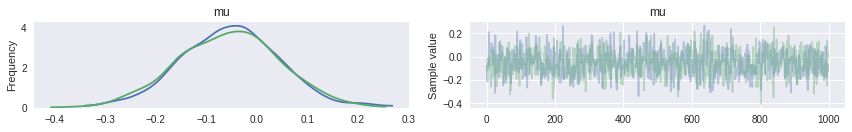

In [39]:
pm.traceplot(trace)

## multiple chains in Parallel using **cores**


In [44]:
with pm.Model() as model :
    mu = pm.Normal("mu" , mu=0, sd=1)
    obs =pm.Normal("obs" , mu=mu ,sd=1 , observed = np.random.randn(100))
    
    trace = pm.sample(cores=10)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (10 chains in 10 jobs)
NUTS: [mu]
100%|██████████| 1000/1000 [00:02<00:00, 366.21it/s]
/usr/local/lib/python3.6/dist-packages/scipy/signal/signaltools.py:375: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  complex_result = (np.issubdtype(in1.dtype, complex) or
/usr/local/lib/python3.6/dist-packages/scipy/signal/signaltools.py:376: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  np.issubdtype(in2.dtype, complex))
The acceptance probability does not match the target. It is 0.8860369307464134, but should be close to 0.8. Try to increase the number of tuning steps.


In [46]:
trace["mu"].shape

(5000,)

*  500 samples for 10chains each. The 500 tuning samples are discarded by default.

In [48]:
trace.nchains

10

In [51]:
# # get values of a single chain
trace.get_values("mu", chains =2).shape

(500,)

# 다양한 samplers 방법 제공 in Pymc3

## pm.step_methods

* 이중에서 Nuts 근처에 잇는  Metropolis 와 Slice 가 많이 사용 된다
*   바로 **모든 연속형 모델은 NUTS 를 선호한다**
*  **NUTS**는 빠르지만 복잡한 모델이나 초기화를 나쁘게 하면 느릴 수 있다 . 
* Metropolis 나 Nuts 는 복잡하면 느릴 수 있지만 적절하게 수렴하지 않을 때나 효과적은 샘플이 적을 때는 굉장히 유용하다 
*  이것을 더 향상시킨 것은 **reparameterized the model**이 있다.

In [52]:
list(filter(lambda x: x[0].isupper(), dir(pm.step_methods)))

['BinaryGibbsMetropolis',
 'BinaryMetropolis',
 'CSG',
 'CategoricalGibbsMetropolis',
 'CauchyProposal',
 'CompoundStep',
 'DEMetropolis',
 'ElemwiseCategorical',
 'EllipticalSlice',
 'HamiltonianMC',
 'LaplaceProposal',
 'Metropolis',
 'MultivariateNormalProposal',
 'NUTS',
 'NormalProposal',
 'PoissonProposal',
 'SGFS',
 'SMC',
 'Slice']

Multiprocess sampling (10 chains in 10 jobs)
Metropolis: [mu]
100%|██████████| 5500/5500 [00:05<00:00, 928.75it/s]
/usr/local/lib/python3.6/dist-packages/scipy/signal/signaltools.py:375: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  complex_result = (np.issubdtype(in1.dtype, complex) or
/usr/local/lib/python3.6/dist-packages/scipy/signal/signaltools.py:376: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  np.issubdtype(in2.dtype, complex))
The number of effective samples is smaller than 25% for some parameters.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f055023c0b8>,
      dtype=object)

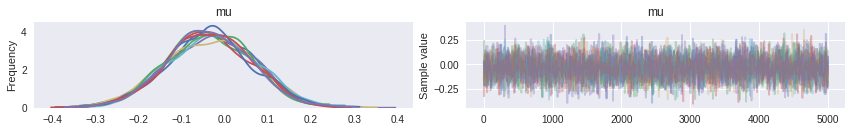

In [57]:
with pm.Model() as model :
    mu  = pm.Normal("mu" , mu=0, sd=1)
    obs = pm.Normal("obs", mu=mu, sd=1 ,observed = np.random.randn(100))
    
    step = pm.Metropolis()
    trace = pm.sample(5000, step= step, cores=10)
    
pm.traceplot(trace)

In [59]:
with pm.Model() as model:
    mu = pm.Normal('mu', mu=0, sd=1)
    sd = pm.HalfNormal('sd', sd=1)
    obs = pm.Normal('obs', mu=mu, sd=sd, observed=np.random.randn(100))

    step1 = pm.Metropolis(vars=[mu])
    step2 = pm.Slice(vars=[sd])
    trace = pm.sample(10000, step=[step1, step2], cores=4)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [mu]
>Slice: [sd_log__]
100%|██████████| 10500/10500 [00:22<00:00, 474.82it/s]
/usr/local/lib/python3.6/dist-packages/scipy/signal/signaltools.py:375: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  complex_result = (np.issubdtype(in1.dtype, complex) or
/usr/local/lib/python3.6/dist-packages/scipy/signal/signaltools.py:376: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  np.issubdtype(in2.dtype, complex))
The number of effective samples is smaller than 25% for some parameters.


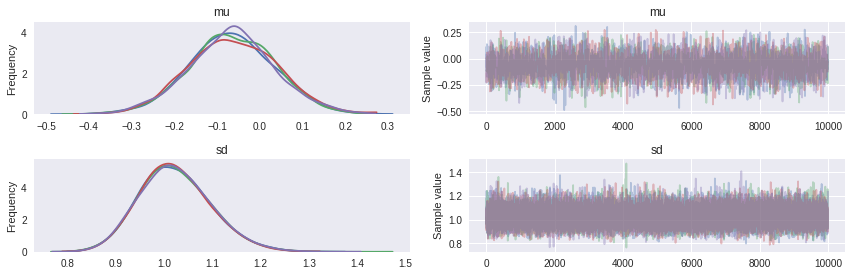

In [60]:
pm.traceplot(trace);

In [61]:
pm.gelman_rubin(trace)

{'mu': 1.00006806693418, 'sd': 1.000001965509287}

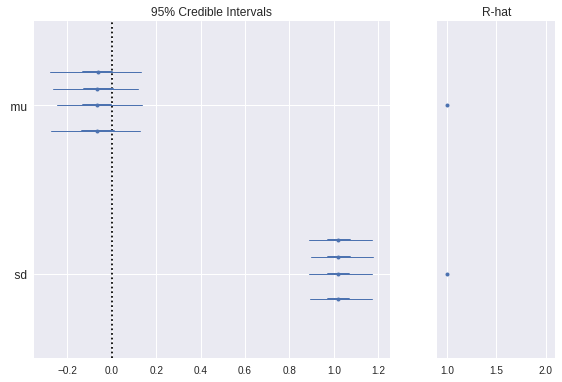

In [62]:
pm.forestplot(trace)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f055e38d3c8>,
      dtype=object)

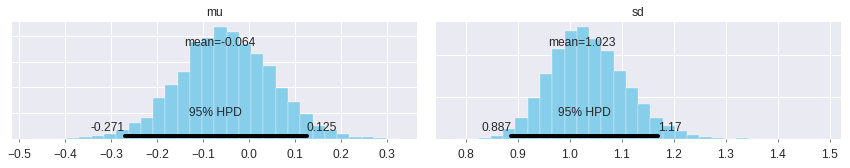

In [64]:
pm.plot_posterior(trace)

* 높은 차원이 모델에서는 모든 파리미터를 추적하기 어려울 것이다 
* 그때 **NUTS**를 사용하여 수렴의 문제를 energy plot으로 접근이 가능하다


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [x]
100%|██████████| 1000/1000 [00:07<00:00, 133.77it/s]
/usr/local/lib/python3.6/dist-packages/scipy/signal/signaltools.py:375: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  complex_result = (np.issubdtype(in1.dtype, complex) or
/usr/local/lib/python3.6/dist-packages/scipy/signal/signaltools.py:376: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  np.issubdtype(in2.dtype, complex))


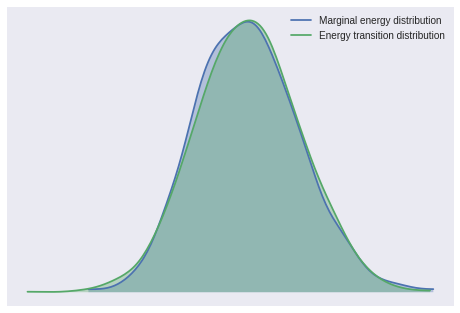

In [66]:

with pm.Model() as model:
    x = pm.Normal('x', mu=0, sd=1, shape=100)
    trace = pm.sample(cores=4)

pm.energyplot(trace);

## Variational Inference

* 빠른 반면에 정확도가 조금 떨어지고 편향된 추론을 할 수 있다 

## pymc3.fit()

* **Approximation** 은 다양하게 사용가능하다 마치 근사화한 사후분포로부터 샘플링을 하는 것 같은 역할을 한다.

In [67]:
with pm.Model() as model :
    mu = pm.Normal("mu" , mu=0, sd=1)
    sd= pm.HalfNormal("sd", sd=1)
    obs =pm.Normal("obs", mu=mu ,sd=sd, observed = np.random.randn(100))
    
    approx = pm.fit()

Average Loss = 147.82: 100%|██████████| 10000/10000 [00:08<00:00, 1147.30it/s]


Finished [100%]: Average Loss = 147.81


In [68]:
approx.sample(500)

<MultiTrace: 1 chains, 500 iterations, 3 variables>

## ADVI 

* variational submodule 에는 많은 VI를 제공한다. 
* 예를 들어 full-rank-ADVI 는 full covariance matrix 를 추정한다.

In [69]:
mu = pm.floatX([0., 0.])
cov = pm.floatX([[1, .5], [.5, 1.]])
with pm.Model() as model:
    pm.MvNormal('x', mu=mu, cov=cov, shape=2)
    approx = pm.fit(method='fullrank_advi')

Average Loss = 0.0068883: 100%|██████████| 10000/10000 [00:17<00:00, 579.36it/s]


Finished [100%]: Average Loss = 0.0065707


In [70]:
with pm.Model() as model:
    pm.MvNormal('x', mu=mu, cov=cov, shape=2)
    approx = pm.FullRankADVI().fit()

Average Loss = 0.01127: 100%|██████████| 10000/10000 [00:16<00:00, 612.36it/s]


Finished [100%]: Average Loss = 0.011343


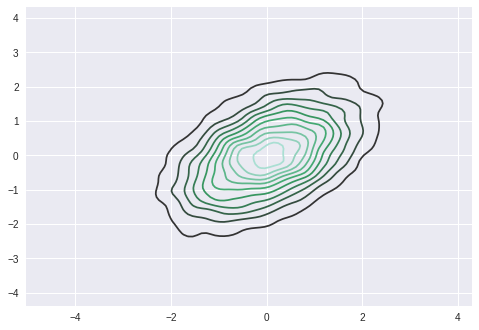

In [71]:
plt.figure()
trace = approx.sample(10000)
sns.kdeplot(trace['x'])

## Stein Variational Gradient Descent (SVGD) uses particles to estimate the posterior: 

In [73]:

w = pm.floatX([.2, .8])
mu = pm.floatX([-.3, .5])
sd = pm.floatX([.1, .1])
with pm.Model() as model:
    pm.NormalMixture('x', w=w, mu=mu, sd=sd)
    approx = pm.fit(method=pm.SVGD(n_particles=200, jitter=1.))

100%|██████████| 10000/10000 [01:17<00:00, 129.82it/s]


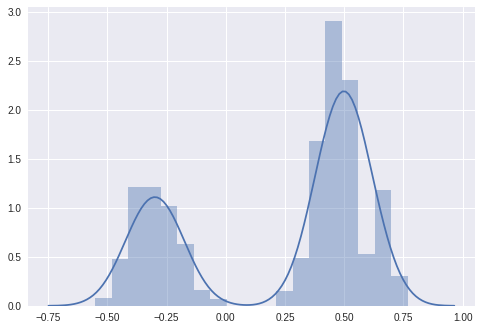

In [74]:
plt.figure()
trace = approx.sample(10000)
sns.distplot(trace['x']);

## Posterior Predictive Sampling

**sample_ppc()** 함수는 예측을 수행한다. 

In [75]:
data = np.random.randn(100)
with pm.Model() as model:
    mu = pm.Normal('mu', mu=0, sd=1)
    sd = pm.HalfNormal('sd', sd=1)
    obs = pm.Normal('obs', mu=mu, sd=sd, observed=data)

    trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sd_log__, mu]
100%|██████████| 1000/1000 [00:00<00:00, 1076.00it/s]
/usr/local/lib/python3.6/dist-packages/scipy/signal/signaltools.py:375: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  complex_result = (np.issubdtype(in1.dtype, complex) or
/usr/local/lib/python3.6/dist-packages/scipy/signal/signaltools.py:376: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  np.issubdtype(in2.dtype, complex))


In [76]:
## Return  모든 관측치 노ㄹ를 리턴한다.
with model:
    post_pred = pm.sample_ppc(trace, samples=500, size=len(data))

100%|██████████| 500/500 [00:01<00:00, 455.05it/s]


In [77]:
post_pred["obs"].shape

(500, 100)

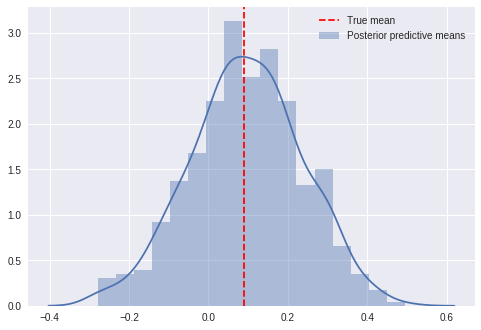

In [78]:
plt.figure()
ax = sns.distplot(post_pred['obs'].mean(axis=1), label='Posterior predictive means')
ax.axvline(data.mean(), color='r', ls='--', label='True mean')
ax.legend()

## Predicting on hold-out data
* 홀드아웃 방법에서는 데이터셋을 훈련 세트와 테스트 세트 두 부분으로 나눕니다. 먼저 훈련 데이터를 지도 학습 알고리즘에 주입합니다
*  보지 않은 데이터에서 예측하는 것을 원하는 데 특히 이것은  **Probabilistic Machine Learning and Bayesian Deep Learning** 과 관계가 있다.
*   in this regard, this can currently be achieved with a theano.shared variable.
*  너가 모들에서 데이터를 직접적으로 넣을 때 Theano permission 을 줄 것이다 그 데이터를 최적화나 상추로 fitting 처리 할 것이다.
* **If you need to change this data later you might not have a way to point at it in the symbolic expression**
* Using **theano.shared** offers a way to point to a place in that symbolic expression, and change what is there.

In [79]:
import theano

x = np.random.randn(100)
y = x > 0

x_shared = theano.shared(x)
y_shared = theano.shared(y)

with pm.Model() as model:
    coeff = pm.Normal('x', mu=0, sd=1)
    logistic = pm.math.sigmoid(coeff * x_shared)
    pm.Bernoulli('obs', p=logistic, observed=y_shared)
    trace = pm.sample()


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [x]
100%|██████████| 1000/1000 [00:00<00:00, 1355.89it/s]
/usr/local/lib/python3.6/dist-packages/scipy/signal/signaltools.py:375: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  complex_result = (np.issubdtype(in1.dtype, complex) or
/usr/local/lib/python3.6/dist-packages/scipy/signal/signaltools.py:376: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  np.issubdtype(in2.dtype, complex))


*  여기서 이제  보지지 않는 데이터를 예측하고 싶다.
* 그때 우리는 **x_shared 와 y_shared**  값을 변경하면 가능하다. 
* 이론적으로 우리는 **y_shared**는 바꿀 필요가 없다 .
* 그러나 **x_shared** 와 매칭시켜주기 위해 있어야한다.

In [80]:
x_shared.set_value([-1, 0, 1.])
y_shared.set_value([0, 0, 0]) # dummy values

with model:
    post_pred = pm.sample_ppc(trace, samples=500)

100%|██████████| 500/500 [00:01<00:00, 483.95it/s]


In [81]:
post_pred['obs'].mean(axis=0)

array([0.018, 0.474, 0.98 ])